In [5]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import seaborn as sns

#these are user defined modules
import plot
import calculate


# CAREER_LENGTH = 15 means the authors who have atleast 15 years of experience
CAREER_LENGTH_LIST = [0,5,10,15,20,25]
CAREER_LENGTH = 5
END_YEAR = 2015

### Cohort Analysis

For each (filtered) cohort analyze how the distribution of publications and citations changes in the cohort over time.
At the beginning all scientists should be equal (they have zero publications and citations). Over time some scientists become more productive and/or successful than others which leads to an increase in the Gini coefficient.

In [6]:
start_time = timeit.default_timer()
print(start_time)

6751351.923357004


### Read Gender details

In [7]:
# read gender details - the column names are name, gender - change it to author, gender
gender = pd.read_csv('./data/name_gender_2017_asiansAsNone_nodup.txt')
print(gender.shape)
gender = gender.drop_duplicates()
print(gender.shape)
# Gender file is full of duplicates. As we use the author's name as ID, duplicate entries provide no extra info
gender.rename(columns={'name':'author'}, inplace=True)
print(gender.head())
print(gender['gender'].unique())
print(gender.groupby('gender').size())

(1704919, 2)
(1704919, 2)
          author gender
0   gareth beale      m
1    graeme earl      m
2  altaf hossain      m
3   faisal zaman      m
4      m. nasser   none
['m' 'none' 'f']
gender
f       255793
m       796975
none    652151
dtype: int64


### Read authors with start and end year details

In [8]:
# Different files exists depending upon their career length

#authorStartEndCareerData = pd.read_csv('./data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')
authorStartEndCareerData = pd.read_csv('./derived-data/authors-scientific-atleast-'+str(CAREER_LENGTH)+'-year.csv')


print('authorStartEndCareerData before filtering - ',authorStartEndCareerData.shape[0])
authorStartEndCareerData = authorStartEndCareerData[authorStartEndCareerData["start_year"] >= 1970]
print('authorStartEndCareerData after filtering - ',authorStartEndCareerData.shape[0])

print("author unique names  - ", authorStartEndCareerData['author'].nunique())
authorStartEndCareerData.head()

authorStartEndCareerData before filtering -  503859
authorStartEndCareerData after filtering -  503859
author unique names  -  503859


,author,start_year,end_year,num_pub,career_length
0,'maseka lesaoana,2001,2015,2,15
1,a aart blokhuis,1992,2005,2,14
2,a min tjoa,1979,2017,191,39
3,a-imam al-sammak,1992,2006,3,15
4,a-long jin,2011,2016,9,6


### Merge credible authors and their gender information

In [9]:
authorStartEndCareerData = pd.merge(authorStartEndCareerData, gender, how="left", on=["author"])
# for authors whose gender not found, replace it with none
authorStartEndCareerData['gender'] = authorStartEndCareerData['gender'].fillna('none')

# print("authorStartEndCareerData with duplicates: ", authorStartEndCareerData.shape[0])
# authorStartEndCareerData = authorStartEndCareerData.drop_duplicates()
print("authorStartEndCareerData no duplicates: ", authorStartEndCareerData.shape[0])

authorStartEndCareerData.head()

authorStartEndCareerData no duplicates:  503859


,author,start_year,end_year,num_pub,career_length,gender
0,'maseka lesaoana,2001,2015,2,15,none
1,a aart blokhuis,1992,2005,2,14,none
2,a min tjoa,1979,2017,191,39,none
3,a-imam al-sammak,1992,2006,3,15,m
4,a-long jin,2011,2016,9,6,none


### Read Citation data (uses author->author network)

In [10]:
authorCitationsData = pd.read_csv('derived-data/author-author-citations.csv')
# Using file made by daniel

#id1 represents the author who cited
#id2 is the author who has been cited by id1 in year Y
authorCitationsData.rename(columns={'author_cited':'author', 'year_cit':'year'}, inplace=True)

print('authorCitationsData before filtering - ',authorCitationsData.shape[0])
authorCitationsData = authorCitationsData[authorCitationsData["year"] >= 1970]
print('authorCitationsData after filtering - ',authorCitationsData.shape[0])

#Group by both year and author - multi index and hierarchial indexing
authorCitationsData = authorCitationsData.groupby(['year','author']).count().reset_index()
authorCitationsData.rename(columns={'author_citing':'num_cit'}, inplace=True)
print(authorCitationsData.head())

print('authorCitationsData after grouping - ',authorCitationsData.shape)

authorCitationsData[authorCitationsData.author == "stefano rizzi"].head()

##remove wrong data
#authorCitationsData = authorCitationsData[authorCitationsData["year"] > 1900]
#print(authorCitationsData[authorCitationsData.author=="a min tjoa"])

authorCitationsData before filtering -  260116799
authorCitationsData after filtering -  260098696
   year          author  num_cit
0  1970     a. a. afifi        3
1  1970   a. b. carroll        3
2  1970   a. bensoussan        7
3  1970  a. c. mckellar        1
4  1970   a. d. wallace        2
authorCitationsData after grouping -  (7080626, 3)


,year,author,num_cit
260040,1993,stefano rizzi,2
358799,1995,stefano rizzi,12
418807,1996,stefano rizzi,19
487499,1997,stefano rizzi,7
564294,1998,stefano rizzi,18


### Merge Citations with credible authors and their gender information

In [11]:
authorCitationsData = pd.merge(authorCitationsData, authorStartEndCareerData,  
                                          how="left", left_on="author", right_on="author")
print("authorCitationsData before filtering: %s", authorCitationsData.shape[0])
authorCitationsData = authorCitationsData.dropna(how='any')
print("authorCitationsData after filtering: %s", authorCitationsData.shape[0])

authorCitationsData before filtering: %s 7080626
authorCitationsData after filtering: %s 4525132


In [12]:
authorCitationsData.head()

,year,author,num_cit,start_year,end_year,num_pub,career_length,gender
40,1970,alfonso f. cardenas,2,1970.0,2011.0,48.0,42.0,m
81,1970,b. f. caviness,2,1970.0,1986.0,13.0,17.0,m
87,1970,ben wegbreit,9,1970.0,2011.0,30.0,42.0,none
159,1970,chin tung,2,1970.0,1976.0,3.0,7.0,none
215,1970,david michael ritchie park,2,1970.0,1983.0,7.0,14.0,none


476909
     year                      author  num_cit  start_year  end_year  num_pub  \
40   1970         alfonso f. cardenas        2      1970.0    2011.0     48.0   
81   1970              b. f. caviness        2      1970.0    1986.0     13.0   
87   1970                ben wegbreit        9      1970.0    2011.0     30.0   
159  1970                   chin tung        2      1970.0    1976.0      3.0   
215  1970  david michael ritchie park        2      1970.0    1983.0      7.0   

     career_length gender  
40            42.0      m  
81            17.0      m  
87            42.0   none  
159            7.0   none  
215           14.0   none  


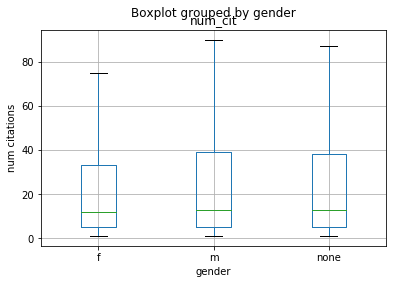

In [13]:
#print(authorCitationsData.head(n=2))
print(authorCitationsData['author'].nunique())
#print(authorCitationsData.shape[0])

print(authorCitationsData.head())
#print(authorCitationsData[authorCitationsData.author=="stefano rizzi"])


ax = authorCitationsData.boxplot(column='num_cit', by='gender', showfliers=False)
ax.set_ylabel("num citations")
ax.set_xlabel("gender")
plt.show()

### There are some differences between publication and citation data which is collected by DBLP and Aminer 
#### Data found for authors whose work were cited in the years which are lesser than their starting year of publishing. For our analysis these data are removed. Whereas author's work will be cited even after he/she ends their career

In [14]:
authorCitationsData.head()

,year,author,num_cit,start_year,end_year,num_pub,career_length,gender
40,1970,alfonso f. cardenas,2,1970.0,2011.0,48.0,42.0,m
81,1970,b. f. caviness,2,1970.0,1986.0,13.0,17.0,m
87,1970,ben wegbreit,9,1970.0,2011.0,30.0,42.0,none
159,1970,chin tung,2,1970.0,1976.0,3.0,7.0,none
215,1970,david michael ritchie park,2,1970.0,1983.0,7.0,14.0,none


In [15]:
print('authorCitationsData before filtering', authorCitationsData.shape[0])
temp =  authorCitationsData[authorCitationsData['year'] < authorCitationsData['start_year']]
print(temp.shape[0],' rows were present')

authorCitationsData = authorCitationsData[authorCitationsData['year'] >= authorCitationsData['start_year']]
authorCitationsData = authorCitationsData.reset_index(drop = True)

print('authorCitationsData after filtering', authorCitationsData.shape[0])
authorCitationsData.head()

authorCitationsData before filtering 4525132
9570  rows were present
authorCitationsData after filtering 4515562


,year,author,num_cit,start_year,end_year,num_pub,career_length,gender
0,1970,alfonso f. cardenas,2,1970.0,2011.0,48.0,42.0,m
1,1970,b. f. caviness,2,1970.0,1986.0,13.0,17.0,m
2,1970,ben wegbreit,9,1970.0,2011.0,30.0,42.0,none
3,1970,chin tung,2,1970.0,1976.0,3.0,7.0,none
4,1970,david michael ritchie park,2,1970.0,1983.0,7.0,14.0,none


### Test Data

In [16]:
groupByYearData = authorCitationsData.copy(deep=True)
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 1, 'num_cit')
print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

        year            author  num_cit  start_year  end_year  num_pub  \
59277   1988  donatella sciuto        2      1987.0    2016.0    349.0   
72077   1989  donatella sciuto        1      1987.0    2016.0    349.0   
87621   1990  donatella sciuto        2      1987.0    2016.0    349.0   
105806  1991  donatella sciuto        4      1987.0    2016.0    349.0   
127575  1992  donatella sciuto       13      1987.0    2016.0    349.0   
152754  1993  donatella sciuto       30      1987.0    2016.0    349.0   
182280  1994  donatella sciuto       39      1987.0    2016.0    349.0   
216712  1995  donatella sciuto       62      1987.0    2016.0    349.0   
256291  1996  donatella sciuto       63      1987.0    2016.0    349.0   
301430  1997  donatella sciuto      164      1987.0    2016.0    349.0   

        career_length gender  
59277            30.0      f  
72077            30.0      f  
87621            30.0      f  
105806           30.0      f  
127575           30.0      f  

# Cohort Analysis on all authors for 15 years

#### Select Cohorts based on Start Years

In [17]:
years = authorCitationsData['year'].unique()
years = sorted(years)
print(years)


cohort_start_years = [y for y in years if y < (END_YEAR - CAREER_LENGTH)]
#cohort_start_years = [1974, 1984, 1994]

[1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]


### Cohort Analysis (Num Cit)

/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


plot_cohort_size_gini_cor ---  unique_career_ages:
[1. 2. 3. 4. 5.]


/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:418: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/home/danielkostic/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


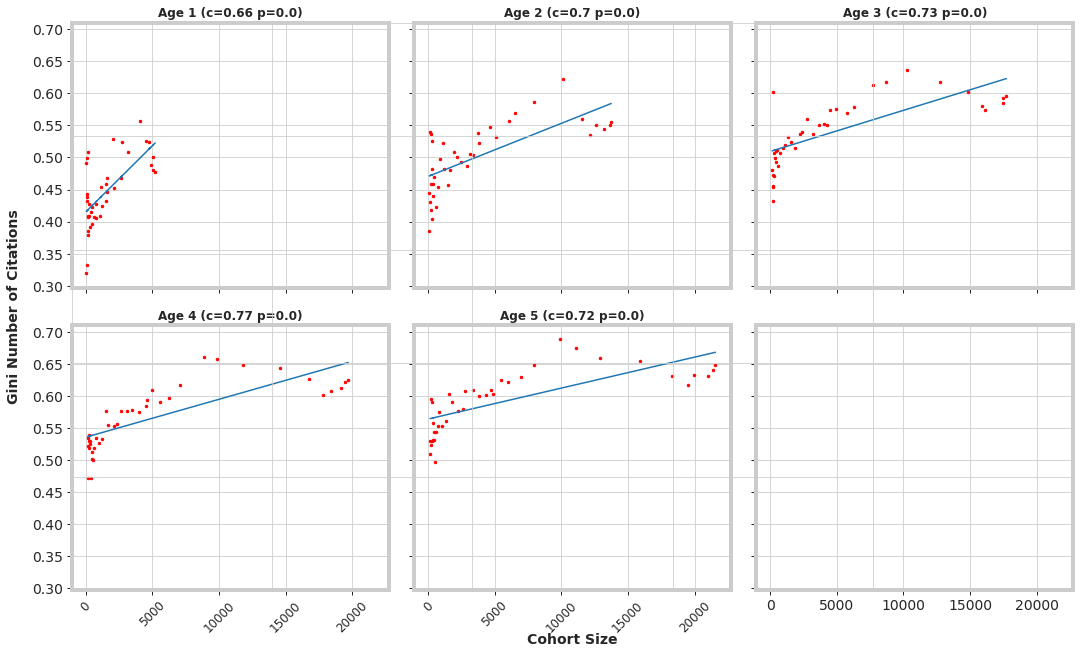

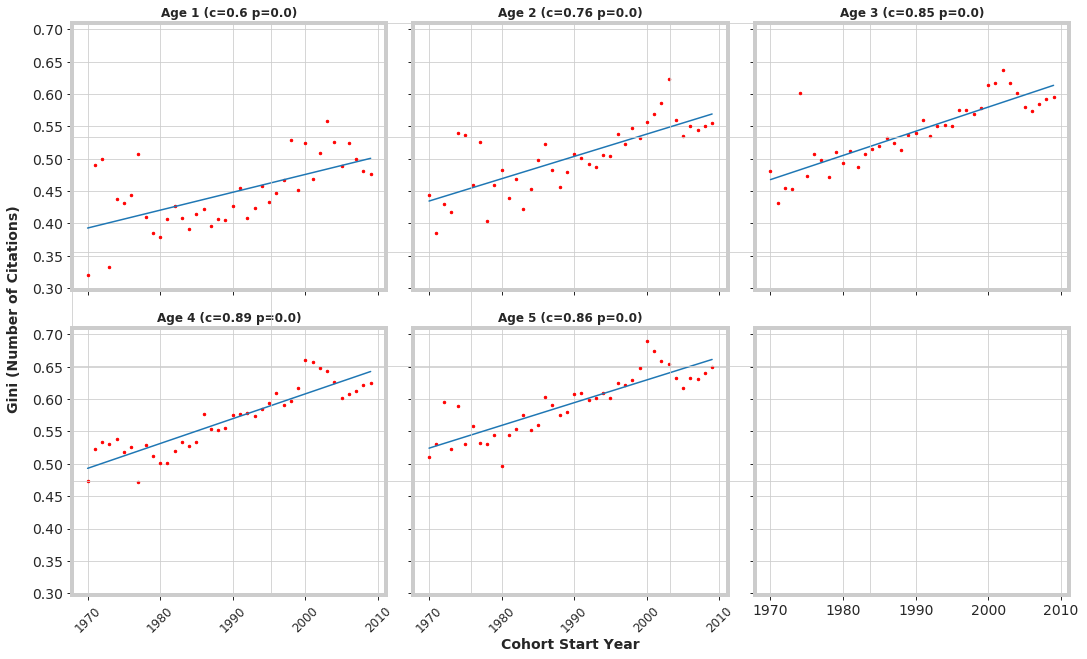

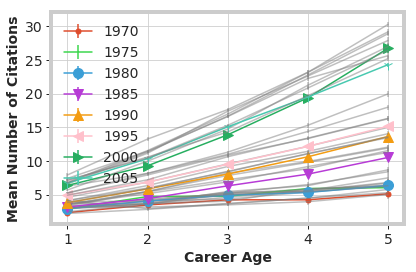

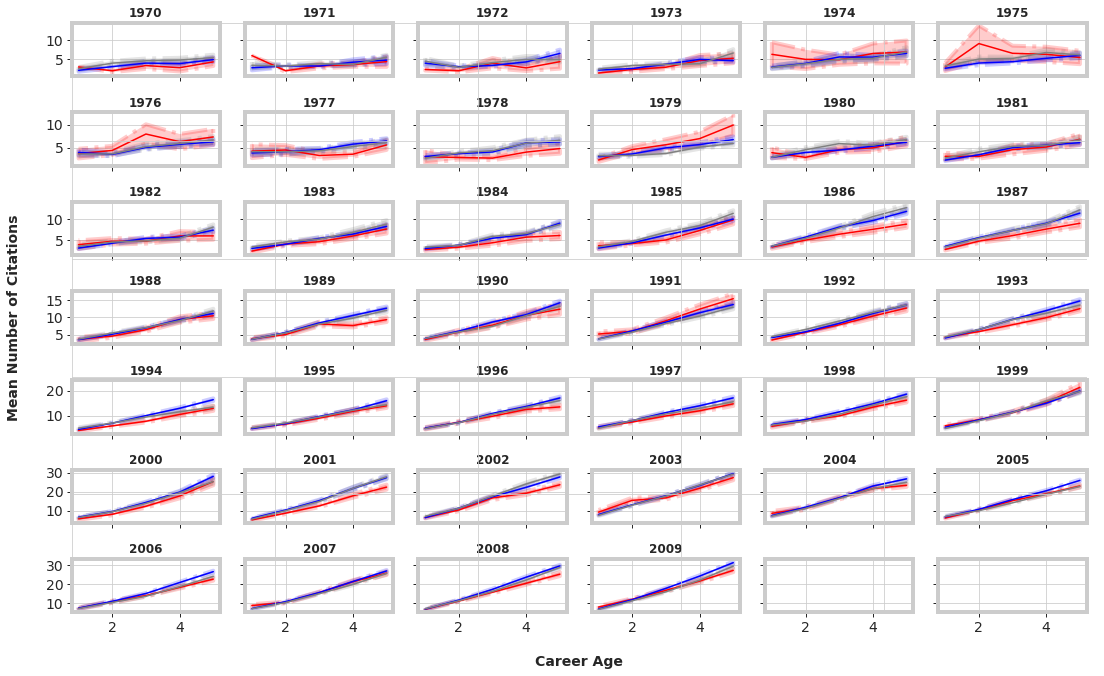

In [18]:
#print(plt.style.available)
from importlib import reload

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', cohort_start_years, CAREER_LENGTH, 'Citations Count')

plot.run_cohort_analysis(authorCitationsData, cohort_start_years, CAREER_LENGTH, "num_cit", "Number of Citations")  


### Cohort Analysis (Cum Num Cit)

In [22]:
authorCitationsData = calculate.groupDataAndCalculateCumulativeValues(authorCitationsData, 1, 'cum_num_cit')

KeyError: 'Column not found: cum_num_cit'

In [ ]:
plot.run_cohort_analysis(authorCitationsData, cohort_start_years, 
                         CAREER_LENGTH, "cum_num_cit", "Cumulative Number of Citations")  

### Cumulative Distributions for Selected Cohorts and Career Ages

how do these distributions differ?

In [ ]:
cohort_start_years = [1970, 1974, 1984, 1994, 1998]

cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'num_cit')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 10, 'num_cit', 'Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 15, 'num_cit', 'Number of Citations')

cohort_careerage_df = plot.get_cohort_careerage_df(authorCitationsData, cohort_start_years, CAREER_LENGTH, 'cum_num_cit')
plot.plot_cumulative_dist(cohort_careerage_df, 1, 'cum_num_cit', 'Cumulative Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 5, 'cum_num_cit', 'Cumulative Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 10, 'cum_num_cit', 'Cumulative Number of Citations')
plot.plot_cumulative_dist(cohort_careerage_df, 15, 'cum_num_cit', 'Cumulative Number of Citations')

### Why is there a sudden increase in mean citation count for cohort started in 1985?

In [ ]:
_1985Authors = authorCitationsData[authorCitationsData['start_year'] == 1985] 
_1985Authors.shape

In [ ]:
_1985Authors.columns

In [ ]:
# _1985Authors.sort_values(by=['num_cit'], axis = 0, ascending=False,inplace=False)

In [ ]:
_1995_year_1985Authors = _1985Authors[_1985Authors['year'] >= 1995]
_1995_2000_year_1985Authors = _1985Authors[_1985Authors['year'] <= 2000]
print(_1995_2000_year_1985Authors.shape)
_1995_2000_year_1985Authors.head(10)

In [ ]:
temp_group = _1995_2000_year_1985Authors.groupby(by=['year','author'])['num_cit']
temp = temp_group.sum().reset_index().sort_values(by='num_cit',ascending=False)
temp.head()

#print(temp1['id2'].unique())

In [ ]:
donatella = _1985Authors[_1985Authors['author'] == 'donatella sciuto']
donatella

In [ ]:
plt.scatter(x=donatella['year'],y=donatella['num_cit'])

In [ ]:
# authorCitationsData[authorCitationsData['author'] == 'donatella sciuto']

## Research Question 1
Is inequality increasing with increasing competition (i.e. do larger cohorts jhave higher inequality?)?
Analyse the correlation plots. Plot signigicance of correlation between cohort size and gini for each career age.

## Research Question 2
How is the position of men and women changing as inequality increases?
We see that the mean cumulative productivity and success are increasing for both groups is a similar way. Some cohorts are different but for most of them no big gender differences are visible.



### Regression Analysis of mean productivity on Inequality for all authors for 15 years
- There is no relation at all - Reg. coefficient is 0

In [ ]:
#just for debugging
reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#print(data.head())

In [ ]:
#just for debugging
#reload(plot)
#reload(calculate)
#data = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 2 years for 15 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 2, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)

### Cohort Analysis, Regression analysis on authors grouped by 3 years for 30 years

In [ ]:
#groupByYearData = authorCitationsData.copy(deep=True)
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))
#groupByYearData = calculate.groupDataAndCalculateCumulativeValues(groupByYearData, 3, 'num_cit')
#print(groupByYearData[groupByYearData['author'] == 'donatella sciuto'].head(10))

#years = groupByYearData['year'].unique()
#years = sorted(years)
#print(years)

#plot.plot_cohort_analysis_on(groupByYearData, 'num_cit', years, 15, 'Citations Count')
#plot.plot_cohort_analysis_on(groupByYearData, 'cum_num_cit', years, 15, 'Cumulative Citations Count')
#data1 = plot.plot_regress_performance_on_inequality(groupByYearData, 'num_cit', years, 15)
#data2 = plot.plot_regress_performance_on_inequality(groupByYearData, 'cum_num_cit', years, 15)